## Introduction to Data Modeling

This project will use a dataset that contains client's profiles and loanhistories. There are 75 columns, and 466285 records of data in thedataset.

## Library and Data Import

In [ ]:
# Library Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
import plotly.express as px

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PORTFOLIO/LOAN PREDICTION ID X/loan_data_2007_2014.csv')

<ipython-input-2-bfbe547ee603>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/PORTFOLIO/LOAN PREDICTION ID X/loan_data_2007_2014.csv')


In [ ]:
print(f'There are {df.shape[1]} columns, and {df.shape[0]} records pf data in the dataset')

There are 75 columns, and 466285 records pf data in the dataset


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

([<matplotlib.patches.Wedge at 0x7f763404b970>,
 [Text(0.6650590580684889, 0.8761828857499183, 'object'),
  Text(-0.6650591401026487, -0.8761828234825914, 'int float')],
 [Text(0.3627594862191757, 0.4779179376817736, '29%'),
  Text(-0.362759530965081, -0.47791790371777704, '71%')])

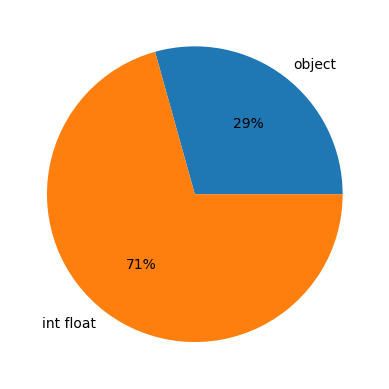

In [ ]:
df_type = pd.DataFrame({'object':['object', 'int float'], 'count' : [len(df.select_dtypes('object').columns), len(df.select_dtypes(['float','int']).columns)]})
plt.pie(df_type['count'], labels = df_type['object'], autopct='%.0f%%')

A total of 29% of the columns in the dataset have the data type "object", while the remaining columns consist of the data types "int" and "float".

The dataset used contains data from 1969, and there are incorrect dates that fall beyond 2023. We will only use data from 1990 to 2014 to maintain relevance.

In [ ]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df = df[(df['earliest_cr_line_date'].dt.year > 1990) & (df['earliest_cr_line_date'].dt.year <= 2014)]

In [ ]:
import plotly.graph_objects as go

# Assume your data is stored in a list called x
fig = go.Figure(data=[go.Histogram(x=df['earliest_cr_line_date'].dt.year)])

# Configure x-axis labels
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        ticktext=df['earliest_cr_line_date'].dt.year,
        tickangle=0,
    ), width = 900
)

# Show the figure
fig.show()

In [ ]:
print(f'There are {df.shape[1]} columns, and {df.shape[0]} records of data in the dataset now')

There are 76 columns, and 389998 records of data in the dataset now


## Risk Definition

To simplify the process, we categorize clients into High Risk clients, consisting of clients with loan statuses 'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', and Low Risk clients, consisting of clients with statuses 'Current', 'Fully Paid', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', 'In Grace Period'.

In [ ]:
list = []
for index, i in df.iterrows():
    if i['loan_status'] in ['Current', 'Fully Paid', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', 'In Grace Period']:
        list.append('Low Risk')
    else:
        list.append('High Risk')
df['Risk'] = list

## Data Preprocessing
**Missing value handling & Feature selection**

Drop columns that have more than 50% missing value, and unused columns with high percentage ofmissing values.

Missing value handling is also done by perform imputation of missing values using the help of SKLearn's IterativeImputer.

In [ ]:
null = pd.DataFrame(df.isnull().sum()).reset_index()
null = null.rename(columns = {0:'null value'})
null['percentage (%)'] = (null['null value']/len(df)*100).round(2)
null[null['percentage (%)'] > 0].sort_values('percentage (%)', ascending = False)

index  null value  percentage (%)
74                 inq_last_12m      389998          100.00
55                    dti_joint      389998          100.00
65                 total_bal_il      389998          100.00
64           mths_since_rcnt_il      389998          100.00
63                  open_il_24m      389998          100.00
62                  open_il_12m      389998          100.00
61                   open_il_6m      389998          100.00
60                  open_acc_6m      389998          100.00
68                  open_rv_24m      389998          100.00
69                   max_bal_bc      389998          100.00
56    verification_status_joint      389998          100.00
54             annual_inc_joint      389998          100.00
67                  open_rv_12m      389998          100.00
70                     all_util      389998          100.00
72                       inq_fi      389998          100.00
73                  total_cu_tl      389998          100.00
66                      il_util      389998          100.00
30       mths_since_last_record      339498           87.05
51  mths_since_last_major_derog      311027           79.75
20                         desc      284905           73.05
29       mths_since_last_delinq      215674           55.30
48                 next_pymnt_d      193567           49.63
71             total_rev_hi_lim       59461           15.25
59                  tot_cur_bal       59461           15.25
58                 tot_coll_amt       59461           15.25
11                    emp_title       18398            4.72
12                   emp_length       13334            3.42
46                 last_pymnt_d         330            0.08
34                   revol_util         269            0.07
50   collections_12_mths_ex_med         100            0.03
49           last_credit_pull_d          35            0.01

Drop columns that have more than 50% missing value.

In [ ]:
null_col = null[null['percentage (%)'] > 50]['index'].to_list()
df_clean = df.drop(null_col, axis = 1).reset_index()
df_clean.shape

(389998, 57)

Check the missing value again

In [ ]:
null = pd.DataFrame(df_clean.isnull().sum()).reset_index()
null = null.rename(columns = {0:'null value'})
null['percentage (%)'] = ((null['null value']/len(df))*100).round(2)
null[null['percentage (%)'] > 0].sort_values('percentage (%)', ascending = False)

index  null value  percentage (%)
46                next_pymnt_d      193567           49.63
52                tot_coll_amt       59461           15.25
53                 tot_cur_bal       59461           15.25
54            total_rev_hi_lim       59461           15.25
12                   emp_title       18398            4.72
13                  emp_length       13334            3.42
44                last_pymnt_d         330            0.08
32                  revol_util         269            0.07
48  collections_12_mths_ex_med         100            0.03
47          last_credit_pull_d          35            0.01

We will drop unused columns with high percentage of missing values

In [ ]:
# Drop unused columns
df_clean = df_clean.drop(['next_pymnt_d','policy_code', 'tot_coll_amt','emp_title', 'title', 'last_pymnt_d', 'last_credit_pull_d', 'title', 'pymnt_plan'], axis = 1)

Imputate missing value of emp_length columns with 0, and do the label encoding

In [ ]:
# Imputate emp_length
df_clean['emp_length'] = df_clean['emp_length'].fillna(0).replace({'< 1 year':0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years':4, '5 years':5, '6 years': 6, '7 years':7, '8 years':8, '9 years':9,'10+ years':10})

Before we do the futher imputation for columns with missing value, we will check the distribution first

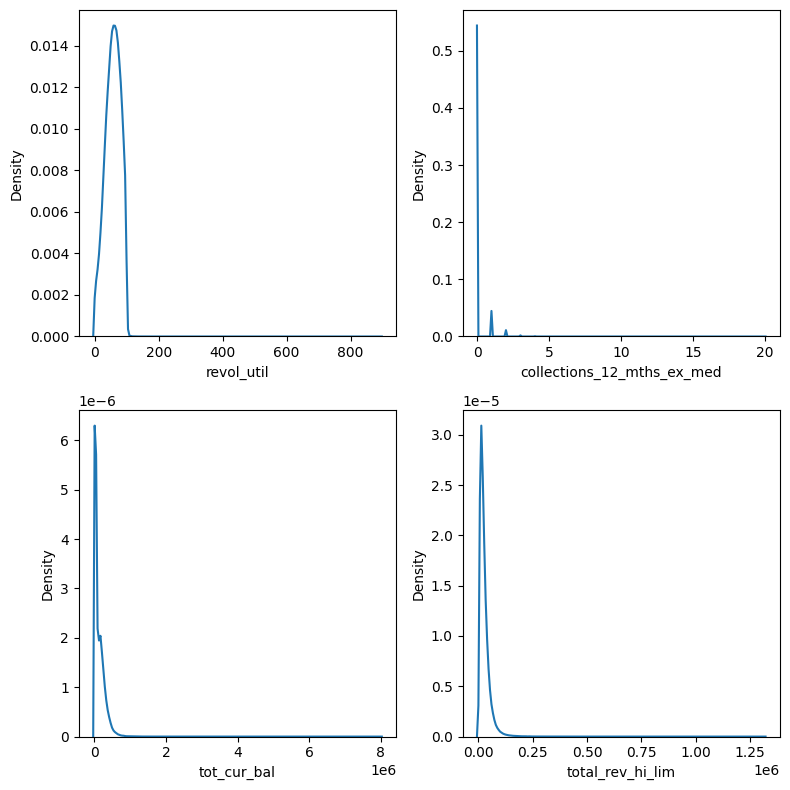

In [ ]:
features_missing = ['revol_util', 'collections_12_mths_ex_med', 'tot_cur_bal', 'total_rev_hi_lim']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for i in range(len(features_missing)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x = df_clean[features_missing[i]])
    plt.tight_layout()

Impute missing value with sklearn IterativeImputer

In [ ]:
# Impute missing value with sklearn IterativeImputer
df_clean_impute = df_clean.copy()
df_clean_impute_col = df_clean[features_missing]
df_clean_no_impute_col = df_clean_impute.drop(features_missing, axis=1)
imputer = IterativeImputer(random_state = 42)
df_clean_after_impute = pd.DataFrame(imputer.fit_transform(df_clean_impute_col), columns=df_clean_impute_col.columns)
df_clean_after_impute.index = df_clean_impute_col.index
df_clean_imputed = pd.concat([df_clean_no_impute_col, df_clean_after_impute], axis=1)

In [ ]:
print('Datasets dimention after imputation', df_clean_after_impute.isnull().sum().sum())
df_clean_imputed.head()

Datasets dimention after imputation 0


index  Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
0      1           1  1077430    1314167       2500         2500   
1      2           2  1077175    1313524       2400         2400   
2      3           3  1076863    1277178      10000        10000   
3      4           4  1075358    1311748       3000         3000   
4      5           5  1075269    1311441       5000         5000   

   funded_amnt_inv        term  int_rate  installment  ...  \
0           2500.0   60 months     15.27        59.83  ...   
1           2400.0   36 months     15.96        84.33  ...   
2          10000.0   36 months     13.49       339.31  ...   
3           3000.0   60 months     12.69        67.79  ...   
4           5000.0   36 months      7.90       156.46  ...   

  collection_recovery_fee last_pymnt_amnt  application_type acc_now_delinq  \
0                    1.11          119.66        INDIVIDUAL            0.0   
1                    0.00          649.91        INDIVIDUAL            0.0   
2                    0.00          357.48        INDIVIDUAL            0.0   
3                    0.00           67.79        INDIVIDUAL            0.0   
4                    0.00          161.03        INDIVIDUAL            0.0   

   earliest_cr_line_date       Risk revol_util collections_12_mths_ex_med  \
0             1999-04-01  High Risk        9.4                        0.0   
1             2001-11-01   Low Risk       98.5                        0.0   
2             1996-02-01   Low Risk       21.0                        0.0   
3             1996-01-01   Low Risk       53.9                        0.0   
4             2004-11-01   Low Risk       28.3                        0.0   

     tot_cur_bal total_rev_hi_lim  
0  112421.710460     36467.169573  
1  148956.974356     20622.617515  
2  117178.265580     34404.354715  
3  130668.840015     28553.784987  
4  120171.614923     33106.203985  

[5 rows x 49 columns]

Checking the distribution after imputation


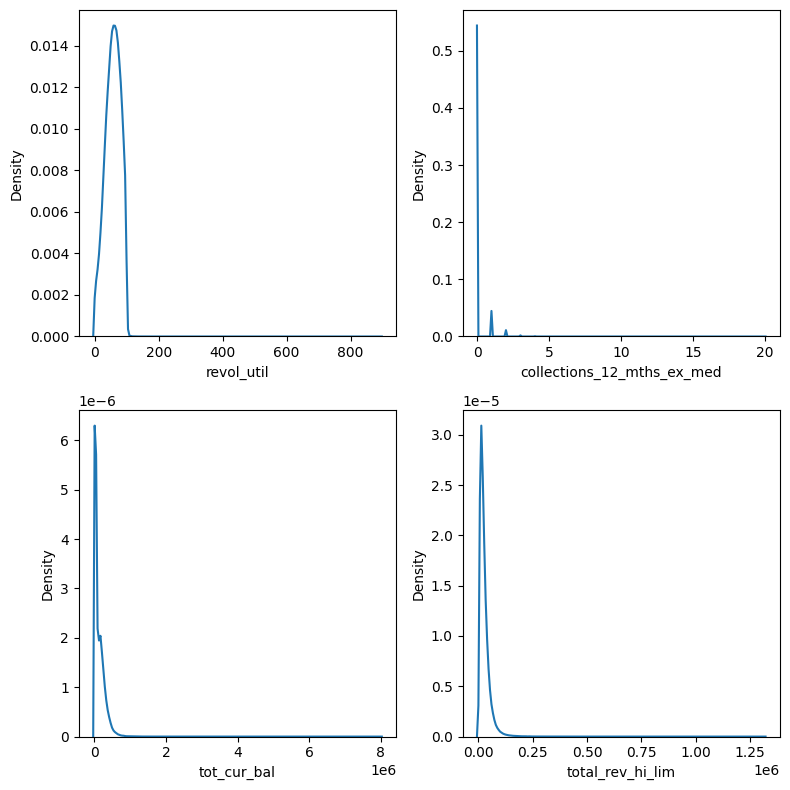

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for i in range(len(features_missing)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x = df_clean[features_missing[i]])
    plt.tight_layout()

In [ ]:
df_clean_imputed.select_dtypes('object')
df_clean_imputed = df_clean_imputed.drop(['loan_status','verification_status', 'issue_d', 'url','application_type', 'sub_grade','purpose', 'zip_code', 'addr_state', 'initial_list_status'], axis = 1)

Make a new 'recency' column from 'earliest_cr_line_date'

In [ ]:
df_clean_imputed['recency'] = (pd.to_datetime(datetime.now().date()) - df_clean_imputed['earliest_cr_line_date'])
df_clean_imputed['recency'] = (df_clean_imputed['recency'].dt.days/365).round(2)
df_clean_imputed = df_clean_imputed.drop('earliest_cr_line', axis = 1)

In [ ]:
df_clean_imputed.select_dtypes('object')

term grade home_ownership       Risk
0        60 months     C           RENT  High Risk
1        36 months     C           RENT   Low Risk
2        36 months     C           RENT   Low Risk
3        60 months     B           RENT   Low Risk
4        36 months     A           RENT   Low Risk
...            ...   ...            ...        ...
389993   60 months     C       MORTGAGE   Low Risk
389994   60 months     D       MORTGAGE  High Risk
389995   60 months     D       MORTGAGE   Low Risk
389996   36 months     A            OWN   Low Risk
389997   36 months     D       MORTGAGE   Low Risk

[389998 rows x 4 columns]

**Label Encoding**

Convert categorical variables into numerical form.

In [ ]:
df_clean_imputed['term'] = df_clean_imputed['term'].replace({' 36 months':0, ' 60 months':1})
df_clean_imputed['grade'] = df_clean_imputed['grade'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6})
df_clean_imputed['home_ownership'] = df_clean_imputed['home_ownership'].replace({'ANY':0, 'MORTGAGE':1,'OTHER':0, 'OWN':0, 'RENT':1, 'NONE':0})

**Duplicated Value**

In [ ]:
df_clean_imputed.duplicated().sum()

0

**Handling Multicollinearity**

This is done to avoid having redundant features that are highly correlated with each other. This step is performed by checking vif score and dropping features that have high correlation with other features.

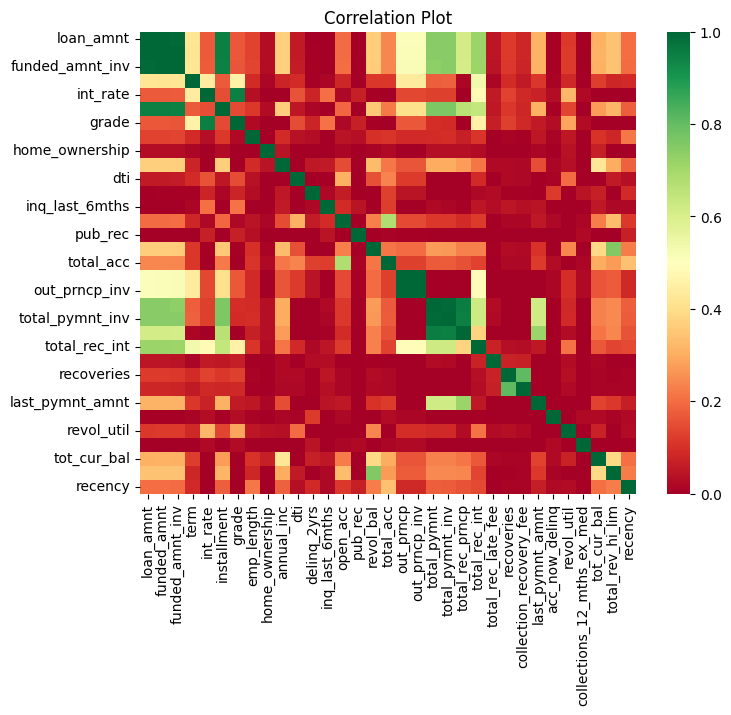

In [ ]:
features = df_clean_imputed.drop(['id', 'member_id','Risk', 'earliest_cr_line_date', 'index', 'Unnamed: 0'], axis = 1)
correlation_matrix = features.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='RdYlGn', vmin = 0, vmax = 1)
plt.title('Correlation Plot')
plt.show()

In [ ]:
X = add_constant(features)
vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index = X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df.sort_values('vif_score', ascending = False)

feature     vif_score
20                 total_pymnt  4.170000e+13
22             total_rec_prncp  3.022550e+13
23               total_rec_int  3.754564e+12
25                  recoveries  1.863224e+11
24          total_rec_late_fee  1.767448e+07
18                   out_prncp  3.017191e+05
19               out_prncp_inv  3.016849e+05
2                  funded_amnt  1.291740e+03
3              funded_amnt_inv  8.561196e+02
21             total_pymnt_inv  8.037383e+02
1                    loan_amnt  3.684187e+02
6                  installment  5.788378e+01
5                     int_rate  1.295010e+01
7                        grade  1.154177e+01
4                         term  7.473097e+00
32            total_rev_hi_lim  3.921501e+00
16                   revol_bal  3.737062e+00
27             last_pymnt_amnt  3.433892e+00
26     collection_recovery_fee  3.013586e+00
17                   total_acc  2.283895e+00
14                    open_acc  2.157588e+00
29                  revol_util  1.813177e+00
10                  annual_inc  1.478972e+00
31                 tot_cur_bal  1.471351e+00
11                         dti  1.329090e+00
33                     recency  1.303615e+00
13              inq_last_6mths  1.141430e+00
12                 delinq_2yrs  1.070184e+00
8                   emp_length  1.070109e+00
15                     pub_rec  1.065333e+00
28              acc_now_delinq  1.017283e+00
9               home_ownership  1.010495e+00
30  collections_12_mths_ex_med  1.005990e+00

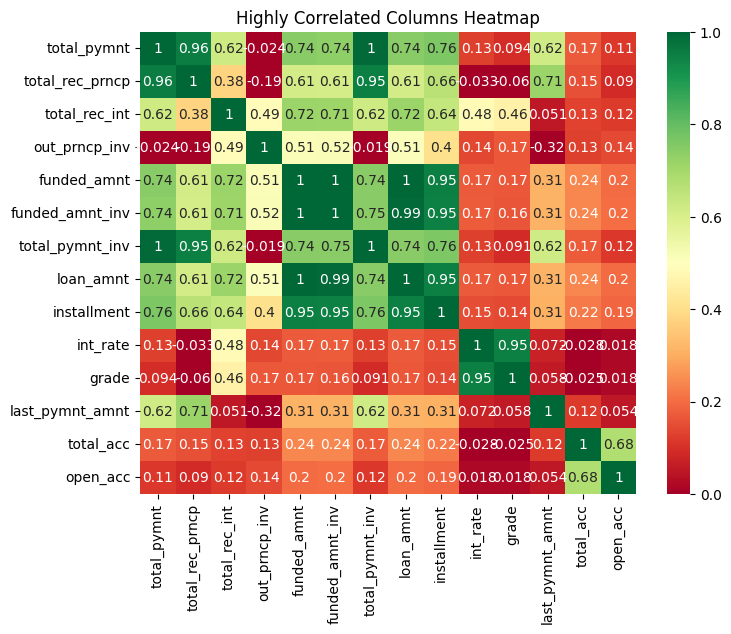

In [ ]:
high_vif = df_clean_imputed[['total_pymnt', 'total_rec_prncp', 'total_rec_int', 'out_prncp_inv', 'funded_amnt', 'funded_amnt_inv', 'total_pymnt_inv', 'loan_amnt', 'installment', 'int_rate', 'grade', 'last_pymnt_amnt','total_acc', 'open_acc']]
correlation_matrix = high_vif.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', vmin = 0, vmax = 1)
plt.title('Highly Correlated Columns Heatmap')
plt.show()

<ipython-input-27-62bf7bad0f39>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



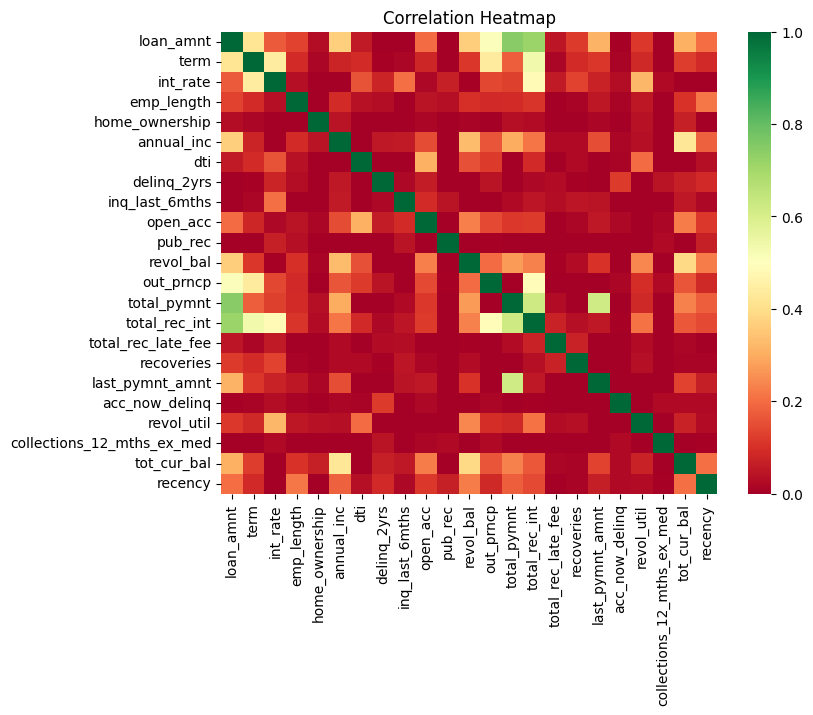

In [ ]:
df_clean_imputed_corr = df_clean_imputed.drop(['id', 'earliest_cr_line_date', 'index', 'Unnamed: 0', 'out_prncp_inv', 'total_rev_hi_lim', 'collection_recovery_fee', 'total_rec_prncp', 'total_acc', 'funded_amnt_inv', 'total_pymnt_inv', 'funded_amnt', 'installment', 'grade'], axis = 1)
correlation_matrix = df_clean_imputed_corr.drop('member_id', axis = 1).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='RdYlGn', vmin = 0, vmax = 1)
plt.title('Correlation Heatmap')
plt.show()

**Drop Feature with Extreme Unbalanced Value**

Drop features with extremely unbalanced values. This step is done to reduce bias caused by unbalanced data.

In [ ]:
feats = df_clean_imputed_corr.select_dtypes(['float', 'int']).columns
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15,15))
for i in range(len(feats)):
    plt.subplot(5, 5, i+1)
    sns.boxplot (x = df_clean_imputed_corr[feats[i]])
    plt.tight_layout()

<ipython-input-28-a5851693d937>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-28-a5851693d937>:6: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

<ipython-input-28-a5851693d937>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-28-a5851693d937>:6: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

<ipython-input-28-a5851693d937>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-28-a5851693d937>:6: UserWarning:

tight_layout not

**Drop Feature with Extreme Unbalanced Value**

Drop features with extremelyunbalanced values. This step is done toreduce bias caused by unbalanced data.

In [ ]:
for i in ['delinq_2yrs', 'total_rec_late_fee', 'pub_rec', 'acc_now_delinq', 'total_rec_late_fee', 'recoveries', 'collections_12_mths_ex_med']:
  print(i, '\n', df_clean_imputed_corr[i].value_counts())

delinq_2yrs 
 0.0     324372
1.0      45006
2.0      12583
3.0       4257
4.0       1770
5.0        911
6.0        468
7.0        259
8.0        122
9.0         78
10.0        47
11.0        36
12.0        31
13.0        21
14.0         8
15.0         7
18.0         6
16.0         5
17.0         3
21.0         2
22.0         2
19.0         2
29.0         1
24.0         1
Name: delinq_2yrs, dtype: int64
total_rec_late_fee 
 0.000000      380788
15.000000       1967
30.000000        255
45.000000         44
16.640000         14
               ...  
104.942381         1
14.995936          1
47.689526          1
39.216333          1
37.430000          1
Name: total_rec_late_fee, Length: 5111, dtype: int64
pub_rec 
 0.0     340567
1.0      42932
2.0       4483
3.0       1231
4.0        394
5.0        199
6.0         95
7.0         43
8.0         19
9.0         13
10.0         9
11.0         6
19.0         1
16.0         1
15.0         1
18.0         1
13.0         1
34.0         1
17.0     

In [ ]:
df_clean_imputed_corr = df_clean_imputed_corr.drop(['delinq_2yrs', 'total_rec_late_fee', 'pub_rec', 'acc_now_delinq', 'total_rec_late_fee', 'recoveries', 'collections_12_mths_ex_med'], axis = 1)

In [ ]:
print(df_clean_imputed_corr.shape)
df_clean_imputed_corr.head()

(389998, 19)


member_id  loan_amnt  term  int_rate  emp_length  home_ownership  \
0    1314167       2500     1     15.27           0               1   
1    1313524       2400     0     15.96          10               1   
2    1277178      10000     0     13.49          10               1   
3    1311748       3000     1     12.69           1               1   
4    1311441       5000     0      7.90           3               1   

   annual_inc    dti  inq_last_6mths  open_acc  revol_bal  out_prncp  \
0     30000.0   1.00             5.0       3.0       1687        0.0   
1     12252.0   8.72             2.0       2.0       2956        0.0   
2     49200.0  20.00             1.0      10.0       5598        0.0   
3     80000.0  17.94             0.0      15.0      27783      766.9   
4     36000.0  11.20             3.0       9.0       7963        0.0   

    total_pymnt  total_rec_int  last_pymnt_amnt       Risk  revol_util  \
0   1008.710000         435.17           119.66  High Risk         9.4   
1   3003.653644         603.65           649.91   Low Risk        98.5   
2  12226.302210        2209.33           357.48   Low Risk        21.0   
3   3242.170000        1009.07            67.79   Low Risk        53.9   
4   5631.377753         631.38           161.03   Low Risk        28.3   

     tot_cur_bal  recency  
0  112421.710460    24.27  
1  148956.974356    21.68  
2  117178.265580    27.43  
3  130668.840015    27.52  
4  120171.614923    18.67

### Data Preprocessing
**Data Splitting**

Splitting the data into training and test sets is done to divide the data that will beused for training and testing. We use 80% of the data for training and 20% fortesting.

In [ ]:
#Data preparation
#Splitting data train to features and target dataframe
Feature = df_clean_imputed_corr.drop(['member_id', 'Risk'],axis=1)
Target = df_clean_imputed_corr['Risk']

In [ ]:
# Checking feature and target dataframe dimension
print('Shape of Feature : ', Feature.shape)
print('Shape of Target : ', Target.shape)

Shape of Feature :  (389998, 17)
Shape of Target :  (389998,)


In [ ]:
#splitting data (80% data train and 30% data test)
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.30,random_state=0)

In [ ]:
# Checking Train and test dimension
print('Shape of Feature of data train: ', X_train.shape)
print('Shape of Target of data train : ', y_train.shape)
print('Shape of Feature of data test: ', X_test.shape)
print('Shape of Target of data test : ', y_test.shape)

Shape of Feature of data train:  (272998, 17)
Shape of Target of data train :  (272998,)
Shape of Feature of data test:  (117000, 17)
Shape of Target of data test :  (117000,)


**Outlier Handling**

Outlier handling is performed by removing data records with extreme values. This outlier handling is only applied to the training data in order to improve the model's performance and reduce the impact of outliers on the training process. 

<ipython-input-36-34b49dd56dfa>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-36-34b49dd56dfa>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-36-34b49dd56dfa>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-36-34b49dd56dfa>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-36-34b49dd56dfa>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases la

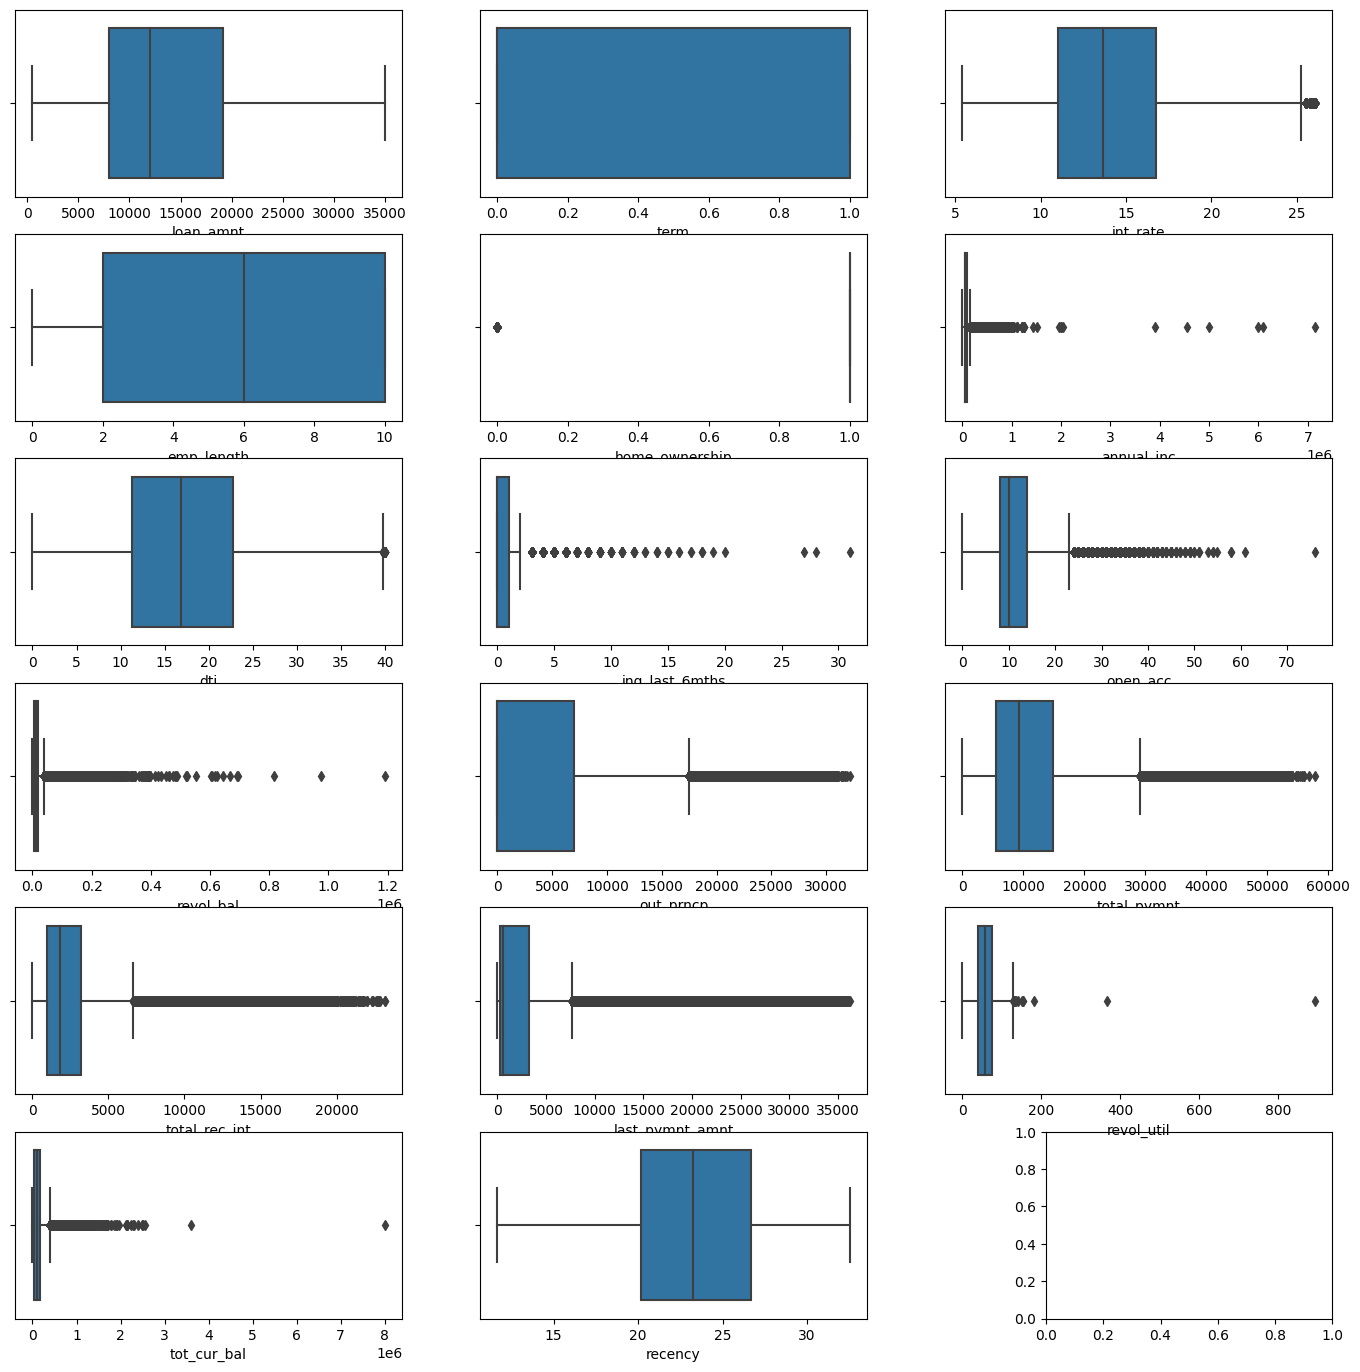

In [ ]:
feat = X_train.columns
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(17,17))
for i in range(len(feat)):
    plt.subplot(6, 3, i+1)
    sns.boxplot (x = X_train[feat[i]])

In [ ]:
# Merge the Xtrain and Y train first
merge_train = pd.concat([X_train,y_train], axis = 1)
merge_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272998 entries, 11504 to 305711
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loan_amnt        272998 non-null  int64  
 1   term             272998 non-null  int64  
 2   int_rate         272998 non-null  float64
 3   emp_length       272998 non-null  int64  
 4   home_ownership   272998 non-null  int64  
 5   annual_inc       272998 non-null  float64
 6   dti              272998 non-null  float64
 7   inq_last_6mths   272998 non-null  float64
 8   open_acc         272998 non-null  float64
 9   revol_bal        272998 non-null  int64  
 10  out_prncp        272998 non-null  float64
 11  total_pymnt      272998 non-null  float64
 12  total_rec_int    272998 non-null  float64
 13  last_pymnt_amnt  272998 non-null  float64
 14  revol_util       272998 non-null  float64
 15  tot_cur_bal      272998 non-null  float64
 16  recency          272998 non-null  

In [ ]:
print(f'Dimention Before Outlier Handling : {len(merge_train)}')
merge_train = merge_train[(merge_train['annual_inc'] < 400000) &
                  (merge_train['revol_bal'] < 800000) &
                  (merge_train['tot_cur_bal'] < 3000000) &
                  (merge_train['revol_util'] < 300)]
print(f'Dimention After Outlier Handling : {len(merge_train)}')

Dimention Before Outlier Handling : 272998
Dimention After Outlier Handling : 272534


<ipython-input-39-186bf4d1727e>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-39-186bf4d1727e>:6: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

<ipython-input-39-186bf4d1727e>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-39-186bf4d1727e>:6: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

<ipython-input-39-186bf4d1727e>:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

<ipython-input-39-186bf4d1727e>:6: UserWarning:

tight_layout not

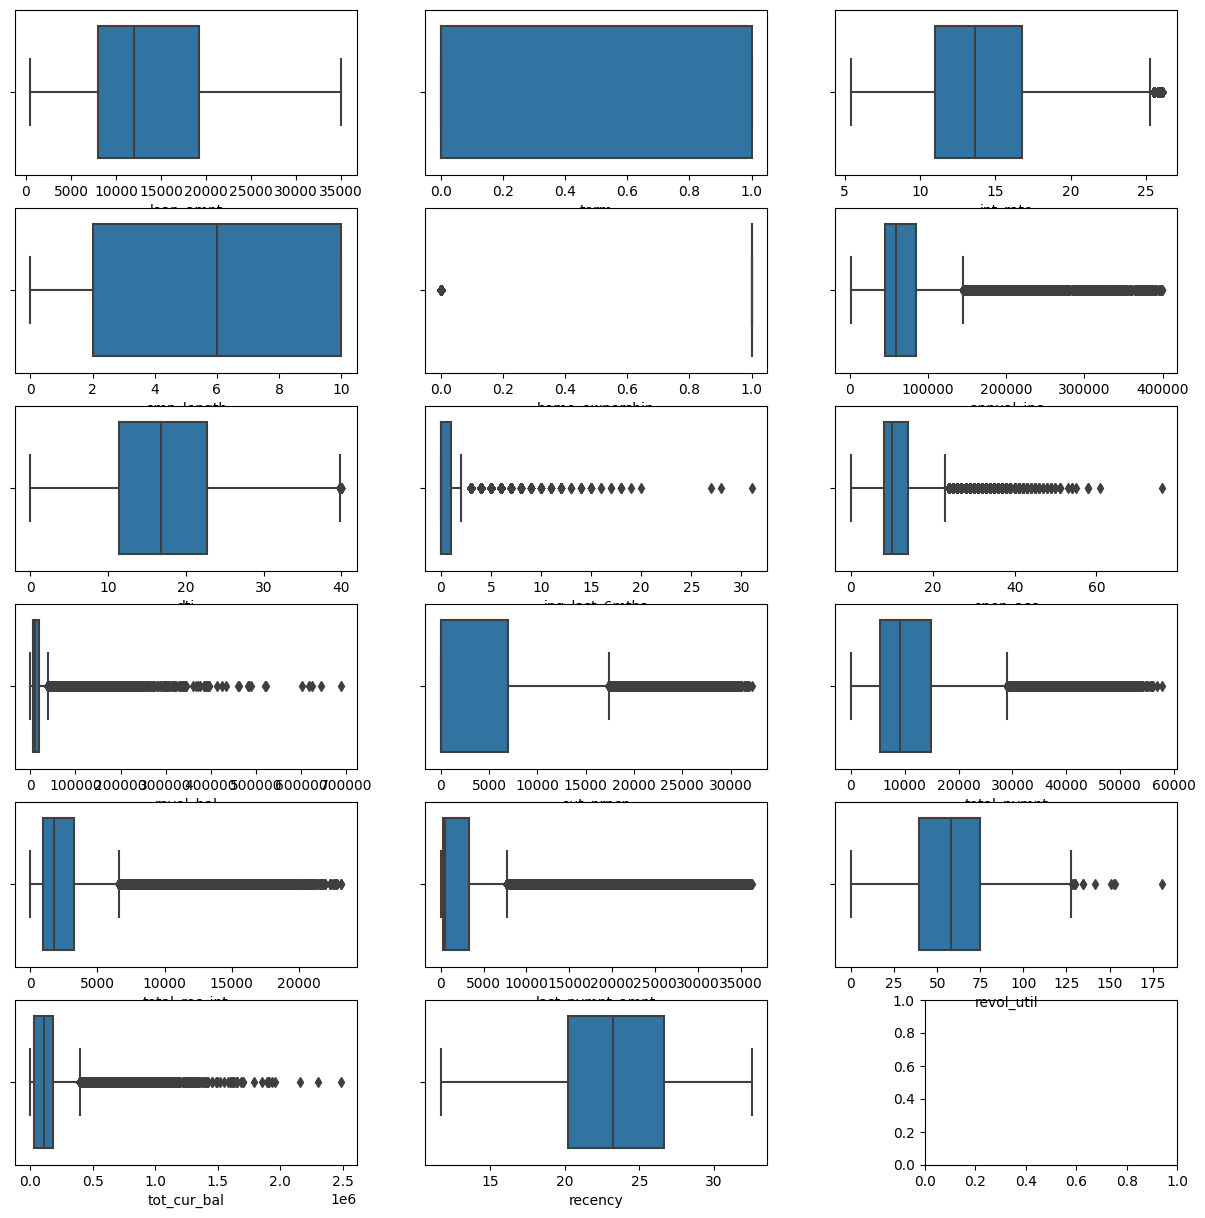

In [ ]:
feat = X_train.columns
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15,15))
for i in range(len(feat)):
    plt.subplot(6, 3, i+1)
    sns.boxplot (x = merge_train[feat[i]])
    plt.tight_layout()

In [ ]:
# split the features and target of X_train
X_train = merge_train.drop('Risk',axis = 1)
y_train = merge_train['Risk']

**Feature Transformation**

Feature log transformation is performed to handle features with extreme skewness, and MinMax scaling is applied to normalize the entire feature set to ensures that all features are on a similar scale.

In [ ]:
# Fix the skewness and distribution
minmaxfeat = ['loan_amnt', 'int_rate', 'dti', 'acc_now_dqliq', 'recency']
minmaxscaler = MinMaxScaler()
minmaxfeat = X_train.columns
X_train[minmaxfeat] = minmaxscaler.fit_transform(X_train[minmaxfeat])
X_test[minmaxfeat] = minmaxscaler.fit_transform(X_test[minmaxfeat])

In [ ]:
#Handling Skewed features
logfeat = ['emp_length', 'annual_inc', 'inq_last_6mths', 'open_acc', 'revol_bal', 'out_prncp', 'last_pymnt_amnt', 'revol_util', 'tot_cur_bal']
epsilon = 1e-10
X_train[logfeat] = np.log(X_train[logfeat] + epsilon)
X_test[logfeat] = np.log(X_test[logfeat] + epsilon)
X_train[logfeat] = minmaxscaler.fit_transform(X_train[logfeat])
X_test[logfeat] = minmaxscaler.fit_transform(X_test[logfeat])

In [ ]:
display(X_train.head())
display(X_test.head())

loan_amnt  term  int_rate  emp_length  home_ownership  annual_inc  \
11504    0.391304   0.0  0.100291    0.984510             1.0    0.898207   
298214   0.275362   0.0  0.143895    1.000000             1.0    0.932072   
344763   0.362319   1.0  0.446705    0.995424             1.0    0.923427   
63242    0.130435   0.0  0.366764    0.960206             1.0    0.887972   
101073   0.318841   0.0  0.588178    1.000000             1.0    0.903278   

             dti  inq_last_6mths  open_acc  revol_bal  out_prncp  total_pymnt  \
11504   0.098275        0.850864  0.911919   0.802632   0.000000     0.271251   
298214  0.518630        0.000000  0.907343   0.712156   0.000000     0.189897   
344763  0.316829        0.000000  0.923313   0.826976   0.946933     0.111518   
63242   0.168792        0.000000  0.896428   0.781805   0.000000     0.067042   
101073  0.644911        0.850864  0.881816   0.773118   0.000000     0.225215   

        total_rec_int  last_pymnt_amnt  revol_util  tot_cur_bal   recency  
11504        0.072165         0.810094    0.876931     0.865700  0.683933  
298214       0.041937         0.921386    0.860134     0.890960  0.543885  
344763       0.126006         0.792776    0.962710     0.771244  0.827818  
63242        0.039117         0.766735    0.949759     0.726073  0.447962  
101073       0.065267         0.940938    0.968002     0.772778  0.495923

loan_amnt  term  int_rate  emp_length  home_ownership  annual_inc  \
166251   0.539855   0.0  0.420058    1.000000             1.0    0.779478   
297267   0.173913   0.0  0.366764    0.977815             1.0    0.727128   
134008   0.275362   0.0  0.479167    0.900000             1.0    0.767727   
209120   0.188406   0.0  0.463663    0.900000             1.0    0.819422   
69810    0.394928   0.0  0.075097    0.930103             1.0    0.779478   

             dti  inq_last_6mths  open_acc  revol_bal  out_prncp  total_pymnt  \
166251  0.457364        0.000000  0.908501   0.830833   0.000000     0.423674   
297267  0.349837        0.000000  0.890892   0.791648   0.879112     0.098738   
134008  0.517379        0.000000  0.890892   0.806190   0.000000     0.220823   
209120  0.031508        0.848149  0.860789   0.775983   0.916655     0.061055   
69810   0.360590        0.848149  0.882974   0.821923   0.000000     0.270020   

        total_rec_int  last_pymnt_amnt  revol_util  tot_cur_bal   recency  
166251       0.186159         0.894849    0.977471     0.773597  0.523741  
297267       0.039659         0.778271    0.965386     0.731331  0.504077  
134008       0.095668         0.906920    0.962283     0.778706  0.444125  
209120       0.043794         0.782725    0.888282     0.715666  0.328058  
69810        0.036084         0.944988    0.930103     0.793682  0.531894

**Imbalance Class Handling**

Imbalance class handling is performed to address the issue of imbalanced class distribution in the dataset. This will be done using undersampling and SMOTE methods. Furthermore, the model results will be compared using the data train without treatment and with imbalance class handling.

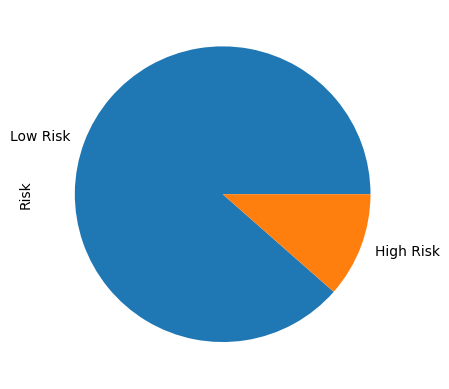

In [ ]:
#Data Train's TARGET distribution
y_train.value_counts().plot(kind='pie')
plt.show()

In [ ]:
y_train = y_train.replace({'Low Risk':0, 'High Risk' : 1})
y_test = y_test.replace({'Low Risk':0, 'High Risk' : 1})

## Data Modeling

Several classification algorithms will be used and their performances will be compared. 

The main metric that will be used is 'recall' because we want to minimize false negatives. Therefore, the algorithm with the highest recall value will be selected. However, it is not solely based on the recall value, other metrics will also be taken into consideration to choose the best model.

**Without Class Imbalance Handling**

In [ ]:
# Define evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)

    print("Confusion Matrix")
    display(cm)
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))

In [ ]:
#Data modeling
#Classification with Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
eval_classification(lr)

Confusion Matrix


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0     1
0  102001  1337
1    3895  9767

Accuracy (Test Set): 0.96
Precision (Test Set): 0.88
Recall (Test Set): 0.71
F1-Score (Test Set): 0.79
roc_auc (train-proba): 0.92
roc_auc (test-proba): 0.93


In [ ]:
#Data modeling
#Classification with Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
eval_classification(dt)

Confusion Matrix


0      1
0  94391   8947
1   2194  11468

Accuracy (Test Set): 0.90
Precision (Test Set): 0.56
Recall (Test Set): 0.84
F1-Score (Test Set): 0.67
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.88


In [ ]:
#Data modeling
#Classification with XGBoost
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)
eval_classification(xg)

Confusion Matrix


0      1
0  103203    135
1    2421  11241

Accuracy (Test Set): 0.98
Precision (Test Set): 0.99
Recall (Test Set): 0.82
F1-Score (Test Set): 0.90
roc_auc (train-proba): 0.99
roc_auc (test-proba): 0.97


In [ ]:
#Data modeling
#Classification with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_classification(rf)

Confusion Matrix


0      1
0  103300     38
1    2867  10795

Accuracy (Test Set): 0.98
Precision (Test Set): 1.00
Recall (Test Set): 0.79
F1-Score (Test Set): 0.88
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.96


**Handling Class Imbalance with SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE oversampling technique
smote = SMOTE()

# Apply SMOTE on X_train and y_train
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Define evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train_smote)
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)

    print("Confusion Matrix")
    display(cm)
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train_smote, y_pred_proba_train[:, 1]))
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))

In [ ]:
#Data modeling
#Classification with Logistic Regression
from sklearn.linear_model import LogisticRegression
lrs = LogisticRegression()
lrs.fit(X_train_smote, y_train_smote)
eval_classification(lrs)

Confusion Matrix


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0      1
0  93652   9686
1   2219  11443

Accuracy (Test Set): 0.90
Precision (Test Set): 0.54
Recall (Test Set): 0.84
F1-Score (Test Set): 0.66
roc_auc (train-proba): 0.94
roc_auc (test-proba): 0.93


In [ ]:
#Data modeling
#Classification with XGBoost
from xgboost import XGBClassifier
xgs = XGBClassifier(random_state=42)
xgs.fit(X_train_smote, y_train_smote)
eval_classification(xgs)

Confusion Matrix


0      1
0  69743  33595
1    719  12943

Accuracy (Test Set): 0.71
Precision (Test Set): 0.28
Recall (Test Set): 0.95
F1-Score (Test Set): 0.43
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.95


In [ ]:
#Data modeling
#Classification with Decision Tree
from sklearn.tree import DecisionTreeClassifier
dts = DecisionTreeClassifier(random_state=42)
dts.fit(X_train_smote, y_train_smote)
eval_classification(dts)

Confusion Matrix


0      1
0  86438  16900
1   1866  11796

Accuracy (Test Set): 0.84
Precision (Test Set): 0.41
Recall (Test Set): 0.86
F1-Score (Test Set): 0.56
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.85


In [ ]:
#Data modeling
#Classification with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfs = RandomForestClassifier(random_state=42)
rfs.fit(X_train_smote, y_train_smote)
eval_classification(rfs)

Confusion Matrix


0      1
0  94891   8447
1   2117  11545

Accuracy (Test Set): 0.91
Precision (Test Set): 0.58
Recall (Test Set): 0.85
F1-Score (Test Set): 0.69
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.94


**Handling Classs Imbalance with Undersampling**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampling strategy
undersampler = RandomUnderSampler(random_state=42)

# Undersample the dataset
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

In [ ]:
# Define evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_undersampled)
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)

    print("Confusion Matrix")
    display(cm)
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_undersampled, y_pred_proba_train[:, 1]))
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))

In [ ]:
#Data modeling
#Classification with Logistic Regression
from sklearn.linear_model import LogisticRegression
lru = LogisticRegression()
lru.fit(X_undersampled, y_undersampled)
eval_classification(lru)

Confusion Matrix


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0      1
0  92254  11084
1   2073  11589

Accuracy (Test Set): 0.89
Precision (Test Set): 0.51
Recall (Test Set): 0.85
F1-Score (Test Set): 0.64
roc_auc (train-proba): 0.93
roc_auc (test-proba): 0.93


In [ ]:
#Data modeling
#Classification with XGBoost
from xgboost import XGBClassifier
xgu = XGBClassifier(random_state=42)
xgu.fit(X_undersampled, y_undersampled)
eval_classification(xgu)

Confusion Matrix


0      1
0  102316   1022
1    2087  11575

Accuracy (Test Set): 0.97
Precision (Test Set): 0.92
Recall (Test Set): 0.85
F1-Score (Test Set): 0.88
roc_auc (train-proba): 0.99
roc_auc (test-proba): 0.97


In [ ]:
#Data modeling
#Classification with Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtu = DecisionTreeClassifier(random_state=42)
dtu.fit(X_undersampled, y_undersampled)
eval_classification(dtu)

Confusion Matrix


0      1
0  78745  24593
1   1546  12116

Accuracy (Test Set): 0.78
Precision (Test Set): 0.33
Recall (Test Set): 0.89
F1-Score (Test Set): 0.48
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.82


In [ ]:
#Data modeling
#Classification with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfu = RandomForestClassifier(random_state=42)
rfu.fit(X_undersampled, y_undersampled)
eval_classification(rfu)

Confusion Matrix


0      1
0  100955   2383
1    2008  11654

Accuracy (Test Set): 0.96
Precision (Test Set): 0.83
Recall (Test Set): 0.85
F1-Score (Test Set): 0.84
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.96


**Finding Best Model**

In [ ]:
score = pd.DataFrame({'Model':['Decision Tree (without)', 'Decision Tree (undersampling)', 'Decision Tree (smote)', 'LogReg (without)', 'LogReg (undersampling)', 'LogReg (smote)', 'Random Forest (without)', 'Random Forest (undersampling)', 'Random Forest (smote)', 'XGB (without)', 'XGB (undersampling)', 'XGB (smote)'],
                      'Accuracy' : [0.9, 0.77, 0.63, 0.97, 0.96, 0.97, 0.98, 0.96, 0.79, 0.98, 0.97, 0.55],
                      'Recall' : [0.84, 0.89, 0.92, 0.72, 0.81, 0.81, 0.79, 0.85, 0.89, 0.82, 0.85, 0.98],
                      'Precision' : [0.56, 0.33, 0.23, 0.99, 0.88, 0.96, 1, 0.83, 0.34, 0.99, 0.92, 0.21],
                      'F1-Score' : [0.67, 0.48, 0.37, 0.84, 0.84, 0.87, 0.88, 0.84, 0.5, 0.9, 0.88, 0.34],
                      'ROC AUC (train)' : [0.94, 1, 1, 0.96, 0.96, 0.97, 1, 1, 1, 0.99, 0.99, 1],
                      'ROC AUD (test)' : [0.88, 0.82, 0.76, 0.95, 0.95, 0.96, 0.96, 0.96, 0.89, 0.97, 0.97, 0.95],
                      'AVG OF SCORE':[0.798, 0.715, 0.652, 0.905, 0.9, 0.923, 0.935, 0.907, 0.735, 0.942, 0.93, 0.672]})
score.set_index('Model', inplace=True)
score

Accuracy  Recall  Precision  F1-Score  \
Model                                                                  
Decision Tree (without)            0.90    0.84       0.56      0.67   
Decision Tree (undersampling)      0.77    0.89       0.33      0.48   
Decision Tree (smote)              0.63    0.92       0.23      0.37   
LogReg (without)                   0.97    0.72       0.99      0.84   
LogReg (undersampling)             0.96    0.81       0.88      0.84   
LogReg (smote)                     0.97    0.81       0.96      0.87   
Random Forest (without)            0.98    0.79       1.00      0.88   
Random Forest (undersampling)      0.96    0.85       0.83      0.84   
Random Forest (smote)              0.79    0.89       0.34      0.50   
XGB (without)                      0.98    0.82       0.99      0.90   
XGB (undersampling)                0.97    0.85       0.92      0.88   
XGB (smote)                        0.55    0.98       0.21      0.34   

                               ROC AUC (train)  ROC AUD (test)  AVG OF SCORE  
Model                                                                         
Decision Tree (without)                   0.94            0.88         0.798  
Decision Tree (undersampling)             1.00            0.82         0.715  
Decision Tree (smote)                     1.00            0.76         0.652  
LogReg (without)                          0.96            0.95         0.905  
LogReg (undersampling)                    0.96            0.95         0.900  
LogReg (smote)                            0.97            0.96         0.923  
Random Forest (without)                   1.00            0.96         0.935  
Random Forest (undersampling)             1.00            0.96         0.907  
Random Forest (smote)                     1.00            0.89         0.735  
XGB (without)                             0.99            0.97         0.942  
XGB (undersampling)                       0.99            0.97         0.930  
XGB (smote)                               1.00            0.95         0.672

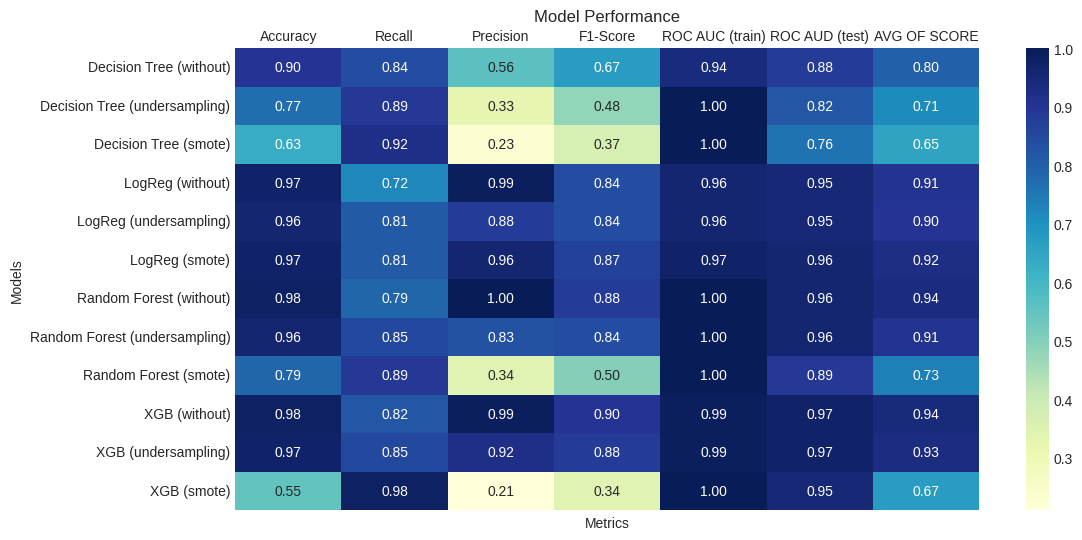

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(score, annot=True, cmap='YlGnBu', fmt='.2f')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title('Model Performance')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

The XGBoost model with datatrain without imbalance handling has the highest average value across all metrics. 

Although the XGBoost model with data train using SMOTE method has a higher recall value, the accuracy of the XGBoost model with data train without imbalance treatment is better. After comparing all the available metrics, we will choose the XGBoost model with data train without imbalance treatment

**Boost Model with Hyperparameter Tuning**

Since the XGBoost model without imbalance class handling has the highest recall score, we will focus on performing hyperparameter tuning on that model only. This hyperparameter tuning will involve tuning the max_depth, learning_rate, and n_estimators.

param value: 10; train: 0.9546011372005166; test: 0.9523638425565997
param value: 20; train: 0.9639031014676717; test: 0.9603615412112559
param value: 30; train: 0.9715672407437302; test: 0.9661197005626893
param value: 40; train: 0.9750049205419086; test: 0.9668775396004825
param value: 50; train: 0.9775602277896251; test: 0.9674351408227873
param value: 60; train: 0.9795510767245423; test: 0.9674545195784279
param value: 70; train: 0.9809325149535442; test: 0.9673449445051625
param value: 80; train: 0.982769122818371; test: 0.9665574115387181
param value: 90; train: 0.9843236465050281; test: 0.9667279196557117
param value: 100; train: 0.9852362459399152; test: 0.9668757064845208


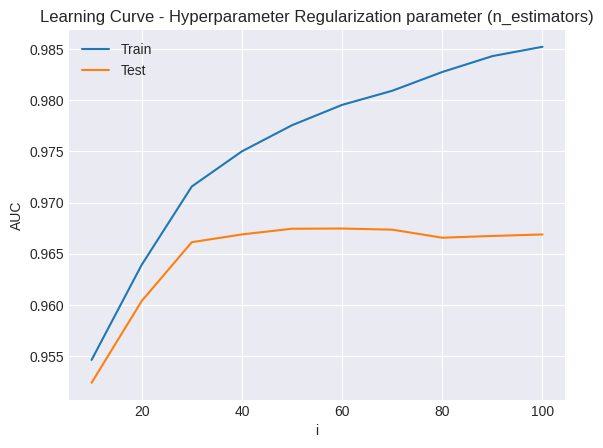

In [ ]:
# learning curve
import numpy as np

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = XGBClassifier(n_estimators = i, random_state = 42)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('i')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter Regularization parameter (n_estimators)')
    plt.legend()
    plt.show()

param_values = [10,20,30,40,50,60,70,80,90,100]
draw_learning_curve(param_values)

param value: 1; train: 0.9417983618565802; test: 0.9430944568899419
param value: 2; train: 0.9565641115617061; test: 0.956575164402665
param value: 3; train: 0.9672204605968416; test: 0.9657912979798022
param value: 4; train: 0.9737011106857905; test: 0.968272086464119
param value: 5; train: 0.9794691702848992; test: 0.9676761392608165
param value: 6; train: 0.9852362459399152; test: 0.9668757064845208
param value: 7; train: 0.990846702047179; test: 0.9661614390123495
param value: 8; train: 0.9957707484739352; test: 0.9622235553111816
param value: 9; train: 0.9976576166508471; test: 0.9637602384307583
param value: 10; train: 0.9991656525066861; test: 0.962362884519766


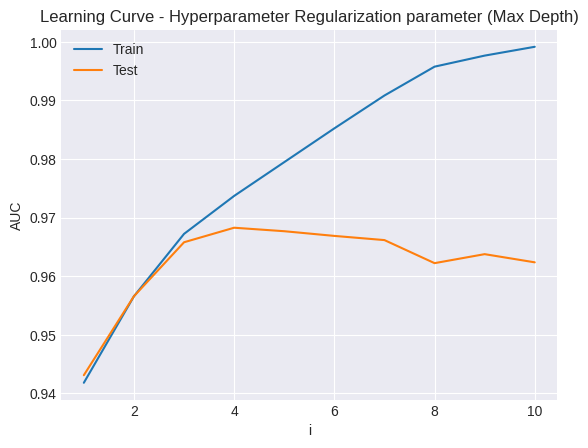

In [ ]:
# learning curve
import numpy as np

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = XGBClassifier(max_depth = i, random_state = 42)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('i')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter Regularization parameter (Max Depth)')
    plt.legend()
    plt.show()

param_values = [1,2,3,4,5,6,7,8,9,10]
draw_learning_curve(param_values)

param value: 0.001; train: 0.9416785287542941; test: 0.9407241058508701
param value: 0.01; train: 0.9475892925084222; test: 0.9462024083182848
param value: 0.1; train: 0.9732965437186835; test: 0.9668800087821836
param value: 1; train: 0.9945326519464379; test: 0.9528148723100578


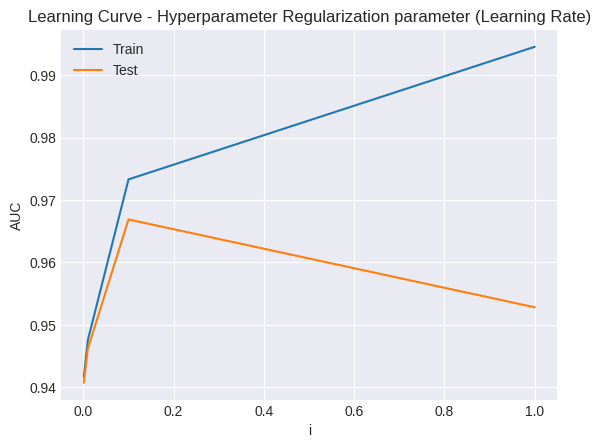

In [ ]:
# learning curve
import numpy as np

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = XGBClassifier(learning_rate = i, random_state = 42)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('i')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter Regularization parameter (Learning Rate)')
    plt.legend()
    plt.show()

param_values = [0.001, 0.01, 0.1, 1]
draw_learning_curve(param_values)

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
hyperparameters = dict(max_depth  = [3,4], n_estimators = [30,40], learning_rate = [0.01])

# Inisialisasi Model
xgb = XGBClassifier(random_state=42)
xgb_tuning = GridSearchCV(xgb, hyperparameters, cv=5, scoring = 'recall')
xgb_tuning.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': [3, 4],
                         'n_estimators': [30, 40]},
             scoring='recall')

In [ ]:
# Predict & Evaluation
eval_classification(xgb_tuning)

Confusion Matrix


0     1
0  99933  3405
1   4661  9001

Accuracy (Test Set): 0.93
Precision (Test Set): 0.73
Recall (Test Set): 0.66
F1-Score (Test Set): 0.69
roc_auc (train-proba): 0.93
roc_auc (test-proba): 0.93


So, it turns out that hyperparameter tuning doesnt give any improvement for the model. So we decided to not use the tuning.

<ipython-input-71-a06becee25c6>:4: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



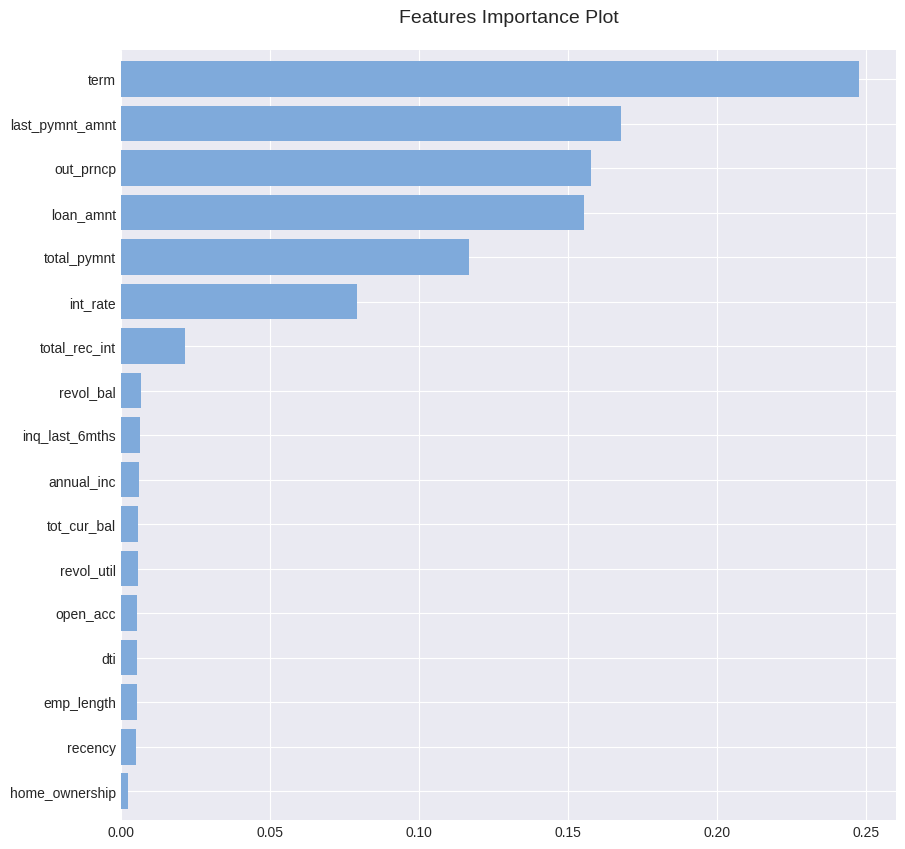

In [ ]:
# important features
importances_rf = pd.Series(xg.feature_importances_, index=X_train.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color='#7faadb', width=1)
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

Term, last payment amount, remaining outstanding principal, and loan amount have the most significant influence on the predictions generated by themodel.

## Conclusion and Business Recommendation

In [ ]:
finaly_pred = xg.predict(X_test)
finalcm = confusion_matrix(y_test, finaly_pred)
finalcm = pd.DataFrame(finalcm)
finalcm

0      1
0  103203    135
1    2421  11241

Out of the 117000 clients in the data test, there are 11241 clients who are correctly predicted to have a high risk level.

**Potential Business Impact**

To simulate the potential business impact, we will use the 117000 clients in the data test. 

In [ ]:
print('Before the model', ((y_test.value_counts()[1]/len(y_test))*100).round(1))
print('After the model', (((y_test.value_counts()[1] - (finalcm[1][1]))/len(y_test))*100).round(1))

Before the model 11.7
After the model 6.9


Assuming the company provides special treatment to clients predicted to be at high risk, and half of the clients correctly predicted to be at high risk are changed to low risk due to our policy, the ratio of high-risk clients can decrease from 11.7% to 6.9%.

Providing special treatment to clients predicted to have a high risk will undoubtedly incur costs, and the problem is that companies usually have limited resources. Therefore, if we want to provide treatment to the right people, it would be better to develop a credit scoring model to prioritize clients who are most deserving of treatment.This allows the company to allocate resources and provide treatment to clients with the highest priority, optimizing the cost-effectiveness of the risk management strategy.